In [52]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy import pi
import math

In [118]:
#global variables
angle = math.radians(45)
velocity = 1 #velocity initialization
t = 1
num_points = 160
steps = num_points

# Example parameters
w1 = 1.0  # Weight for the first term
w2 = 1.0  # Weight for the second term
p = 4     # Prediction Horizon = 5

bnds = ((-12.56, 12.56),(-12.56, 12.56),(-12.56, 12.56),(-12.56, 12.56))

#results:
u = np.zeros(steps + 1)
x_env = np.zeros(steps + 1)
y_env = np.zeros(steps + 1)

#initial points
x_env[0] = 0.5 
y_env[0] = 0.5
u[steps] = 0

u_pred = np.zeros((steps, p))
x_pred = np.zeros((steps, p + 1))
y_pred = np.zeros((steps, p + 1))

ref = np.zeros((2, steps + 1))

print(ref.shape)

(2, 161)


In [81]:
def gen_line_waypoints():
    # Generate 20 consecutive x and y points starting from 1
    x_points = np.arange(1, num_points+2)
    y_points = x_points + 1  # Example: y could be a simple function of x, like x+1
    ref = np.vstack((x_points, y_points))
    return(ref)

In [82]:
def gen_step_waypoints():
    ang = 0  # Start direction (0: right, 1: up, 2: left, 3: down)
    x_points = np.zeros(num_points + 1)
    y_points = np.zeros(num_points + 1)
    x_points[0] = 1
    y_points[0] = 2
    dx = 1  # Initially move right
    dy = 0
    
    for i in range(1, num_points + 1):
        x_points[i] = x_points[i - 1] + dx
        y_points[i] = y_points[i - 1] + dy
        
        # Change direction after every num_points/4 iterations, assuming a perfect square
        if i % (num_points // 40) == 0:
            ang += 1
            if ang == 1:  # Up
                dx, dy = 0, 1
            elif ang == 2:  # Right
                dx, dy = 1, 0
            elif ang == 3:  # Down
                dx, dy = 0, -1
            elif ang == 4:  # Right again
                dx, dy = 1, 0
                ang = 0  # Reset angle to start a new cycle if needed
        
    ref = np.vstack((x_points, y_points))
    return ref

In [83]:
def gen_square_waypoints():
    ang = 0  # Start direction (0: right, 1: up, 2: left, 3: down)
    x_points = np.zeros(num_points + 1)
    y_points = np.zeros(num_points + 1)
    x_points[0] = 1
    y_points[0] = 2
    dx = 1  # Initially move right
    dy = 0
    
    for i in range(1, num_points + 1):
        x_points[i] = x_points[i - 1] + dx
        y_points[i] = y_points[i - 1] + dy
        
        # Change direction after every num_points/4 iterations, assuming a perfect square
        if i % (num_points // 4) == 0:
            ang += 1
            if ang == 1:  # Up
                dx, dy = 0, 1
            elif ang == 2:  # Left
                dx, dy = -1, 0
            elif ang == 3:  # Down
                dx, dy = 0, -1
            elif ang == 4:  # Right again
                dx, dy = 1, 0
                ang = 0  # Reset angle to start a new cycle if needed
        
    ref = np.vstack((x_points, y_points))
    return ref

In [84]:
def gen_sine_waypoints():
    # Generate num_points consecutive x and y points starting from 1
    # Generate random x-coordinates between 0 and 2*pi
    frequency= (2 * np.pi)/ (num_points + 1)
    Period = num_points
    x_vals = np.linspace(0, Period, num_points + 1)
    # Compute corresponding y-coordinates using the sine
    y_vals = np.sin(frequency*x_vals)
    ref = np.vstack((x_vals, y_vals))
    # Generate random offsets for the y-coordinates
    return(ref)

In [85]:
def gen_random_waypoints():
    # Generate num_points consecutive x-coordinates between 0 and num_points+1
    x_val = np.arange(0, num_points+1)
    segmentDivision = 6              ## Equally distribute points
    a = 1                            ## Amplitude
    y = np.zeros_like(x_val, dtype=float)  # Initialize y as floating-point array
    ##Sine Wave Segment Controls
    period = (num_points/segmentDivision)   ### Period Controls how wide the wave is
    frequency  = (2 * np.pi)/period          ### Frequency for sine wave
    length_sine = period
    ###Straight Line Segment
    length_line = num_points/segmentDivision
    #### Ramp Line Segment
    length_ramp = num_points/segmentDivision
    #### Down ramp Line Segment
    length_downramp = num_points/segmentDivision
    #### Straight-down Line Segment
    length_Dline = num_points/segmentDivision

    for K, x in enumerate(x_val):
        if x < length_sine:    ##Sine Wave Segment Interval
            y[K] = np.sin(frequency*x_val[K])
        elif length_sine <= x < (length_sine+length_line):   ## Straigth Line Interval
            y[K] = 0
        elif (length_sine+length_line) <= x < (length_sine+length_line+length_ramp):   ## Ramp Line Interval
            y[K] = x_val[K]/(length_sine+length_line)-1
        elif (length_sine+length_line+length_ramp) <= x < (length_sine+length_line+length_ramp+length_downramp): ##Down Ramp Interval
            y[K] = -x_val[K]/(length_sine+length_line)+2
        elif (length_sine+length_line+length_ramp+length_downramp) <= x < (length_sine+(2*length_line)+length_ramp+length_downramp): ## Straigth Line Interval
            y[K] = 0
        elif (length_sine+(2*length_line)+length_ramp+length_downramp) <= x <= num_points:   ## Parabola Interval
            y[K] = (1/1000)*(x_val[K]-(length_sine+(2*length_line)+length_ramp+length_downramp))**2

  ## Make Reference Trajectory Array
    ref = np.vstack((x_val, a*y))
    return(ref)

In [86]:
def assign_trajectory(trajectory_type): #WIP!!!!!!!!
    if trajectory_type == "line":
        ref = gen_line_waypoints()
        velocity = 1.414
    elif trajectory_type == "square":
        ref = gen_square_waypoints()
        velocity = 1.1
    elif trajectory_type == "step":
        ref = gen_step_waypoints()
        velocity = 1.2
    elif trajectory_type == "sine":
        ref = gen_sine_waypoints()
        velocity = 0.999
    elif trajectory_type == "random":
        ref = gen_random_waypoints()
        velocity = 0.999
    else:
        raise ValueError("Invalid trajectory_type. Choose from 'line', 'square', 'step', 'sine', or 'random'.")
    
    return ref, velocity

In [87]:
def extend_trajectory(ref):
    rx = ref[:-1,:][0]
    ry = ref[-1:,:][0]
    
    # Extend rx by repeating the last element p times and appending
    last_element_rx = rx[-1]
    extension_rx = np.full(p, last_element_rx)
    rx = np.concatenate((rx, extension_rx))

    # Extend ry by repeating the last element p times and appending
    last_element_ry = ry[-1]
    extension_ry = np.full(p, last_element_ry)
    ry = np.concatenate((ry, extension_ry))

    # rx_extended and ry_extended are now the extended arrays

    return rx, ry

In [88]:
def cost_function(u, r_x, r_y, x_old, y_old, k):
    """
    Parameters:
    - u: control inputs, an array of size (p,)
    - w1, w2: weights for the two terms of the cost function
    - r_x, r_y: actual values for x and y, each an array of size (p,)
    - x_old, y_old: the initial values of x and y
    - k: starting index (for consistency with previous problem, might not be used here)
    - p: the range for the summation (number of control inputs)

    Returns:
    - cost: the computed cost based on the given parameters
    """
    # Initialize x_new and y_new arrays
    x_new = np.zeros(p)
    y_new = np.zeros(p)
    x_new[0] = x_old + distance * np.cos(u[0])  # First prediction based on initial x_old
    y_new[0] = y_old + distance * np.sin(u[0])  # First prediction based on initial y_old
    
    # Compute subsequent predictions
    for i in range(1, p):
        x_new[i] = x_new[i-1] + np.cos(u[i])
        y_new[i] = y_new[i-1] + np.sin(u[i])
    
    # First term: sum of squared prediction errors for both x and y
    term1 = np.sum((r_x - x_new) ** 2) + np.sum((r_y - y_new) ** 2)
    
    # Second term: sum of squared differences in control inputs
    term2 = np.sum((u[1:p] - u[0:p-1]) ** 2)
    
    # Total cost
    cost = w1 * term1 + w2 * term2
    return cost

In [89]:
def MPC(steps, x_env, y_env):
    k = 0
    for j in range(1, steps + 1):
        k += 1
        x_old = x_env[k - 1] # Initial value of x
        y_old = y_env[k - 1]  # Initial value of y
        
        r_x = rx[k : k+p] # Actual values for x (example)
        r_y = ry[k : k+p]  # Actual values for y (example)
        initial_u = np.zeros(p)  # Initial guess for control inputs

        # Perform optimization
        result = minimize(cost_function, np.zeros(p), args=(r_x, r_y, x_old, y_old, j))

        # Optimized control inputs
        optimized_u = result.x
        #print(f"Optimized control inputs on run {j}: {optimized_u}")
        
        x_values = np.zeros(p + 1)  # Include initial x in the array
        y_values = np.zeros(p + 1)  # Include initial y in the array

        x_values[0] = x_old
        y_values[0] = y_old

        for i in range(1, p + 1):
            x_values[i] = x_values[i - 1] + distance * np.cos(optimized_u[i - 1])
            y_values[i] = y_values[i - 1] + distance * np.sin(optimized_u[i - 1])
            
        u[k - 1] = optimized_u[0]
        x_env[k] = x_values[1]
        y_env[k] = y_values[1]

        u_pred[k - 1, :] = optimized_u
        x_pred[k - 1, :] = x_values
        y_pred[k - 1, :] = y_values
    

In [63]:
def calculate_trajectory_error(env, ref):
    # Extract x and y coordinates from the numpy arrays
    x_env, y_env = env[1, :], env[2, :]
    x_ref, y_ref = ref[0, :], ref[1, :]

    # Calculate the Euclidean distance between corresponding points
    error = np.sqrt((x_env - x_ref)**2 + (y_env - y_ref)**2)

    # Return the overall error
    return np.sum(error)

In [64]:
def calculate_position_error(ref, env):
    # Remove the first and last two points from ref and env
    ref_trimmed = ref[:, 2:-2]
    env_trimmed = env[1:, 2:-2]
    
    # Calculate the Euclidean distance between corresponding points
    error = np.sqrt(np.sum((ref_trimmed - env_trimmed) ** 2, axis=0))
    
    # Calculate the standard deviation of the error
    std_dev = np.std(error)
    
    return std_dev

In [65]:
def save_files(env, x_pred, y_pred, u_pred, ref):
    np.savetxt("Environment_data.csv", env[:,:-2], delimiter = ",")
    np.savetxt("x_pred_data.csv", x_pred[:,:-2], delimiter = ",")
    np.savetxt("y_pred_data.csv", y_pred[:,:-2], delimiter = ",")
    np.savetxt("u_pred_data.csv", u_pred[:,:-2], delimiter = ",")
    np.savetxt("Reference_data.csv", ref[:,:-2], delimiter = ",")

# L-BFGS-B


## Line Trajectory

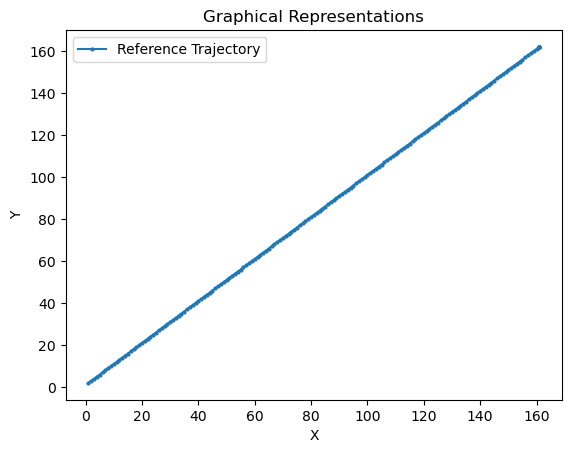

In [16]:
ref, velocity = assign_trajectory("line")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [18]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

### Plot Results:

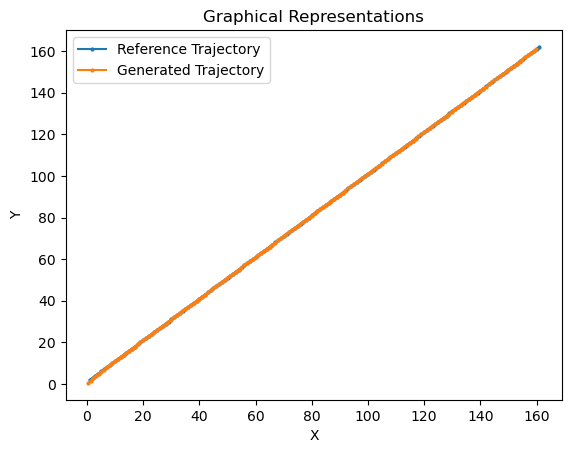

In [19]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(x_env[0:num_points+1], y_env[0:num_points+1], label="Generated Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Line Trajectory.png")
plt.show()

### Error

In [20]:
print(ref.shape)

(2, 161)


In [21]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 235.95582125975488


### Save Files:

In [875]:
save_files(env, x_pred, y_pred, u_pred, ref)

## Step Trajectory:

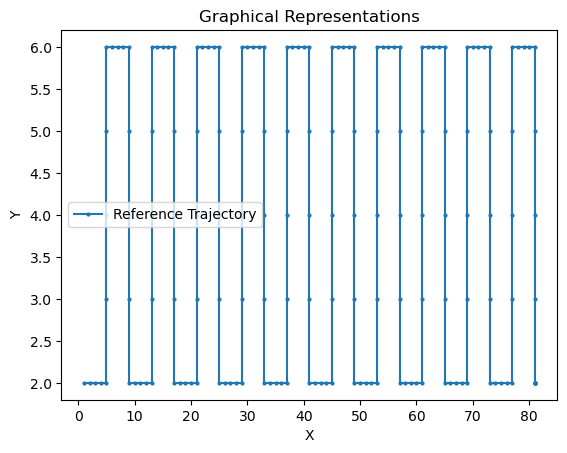

In [90]:
ref, velocity = assign_trajectory("step")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [91]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

### Plot Data

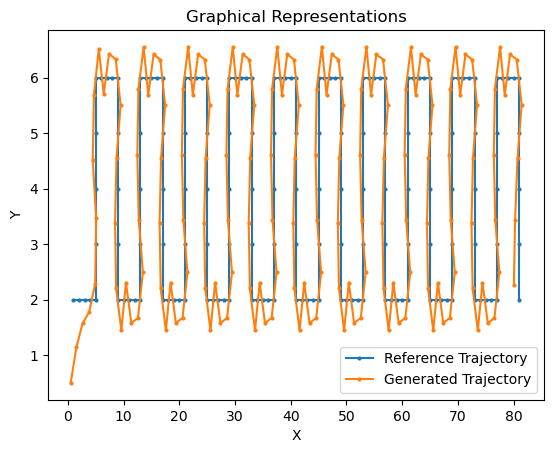

In [92]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(x_env[0:num_points], y_env[0:num_points], label="Generated Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Step Trajectory.png")
plt.show()

### Error

In [93]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 110.39726675688424


In [94]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 22.099018030330217


In [95]:
step_env = env
print(step_env.shape)

(3, 161)


### Save Files

In [885]:
save_files(env, x_pred, y_pred, u_pred, ref)

## Square Trajectory

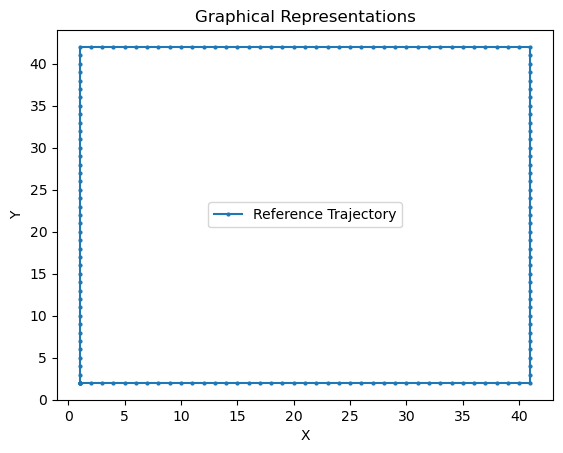

In [66]:
ref, velocity = assign_trajectory("square")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [67]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

### Plot Results:

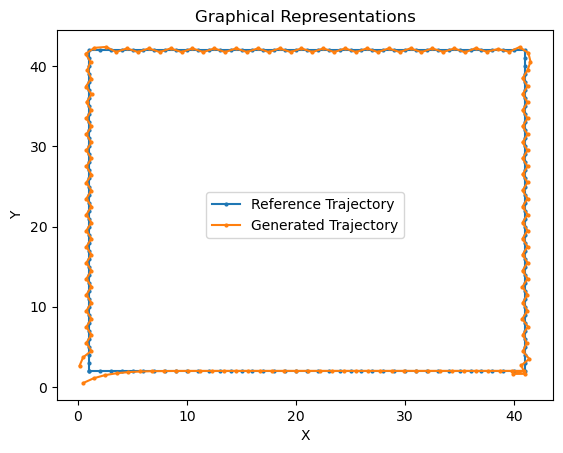

In [68]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(x_env[0:num_points], y_env[0:num_points], label="Generated Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Square Trajectory.png")
plt.show()

### Error

In [69]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 119.31132441090296


In [70]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 14.234136482961032


In [71]:
square_env = env
print(square_env.shape)

(3, 161)


### Save Files

In [895]:
save_files(env, x_pred, y_pred, u_pred, ref)

## Sine Trajectory:

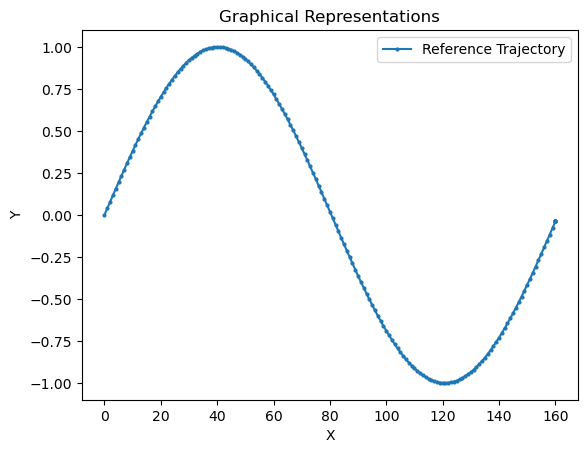

In [34]:
ref, velocity = assign_trajectory("sine")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [35]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

### Plot Data

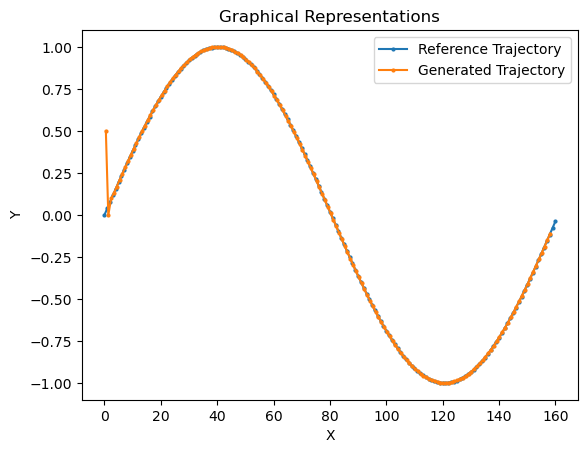

In [36]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(x_env[0:num_points-1], y_env[0:num_points-1], label="Generated Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Sine Wave Trajectory.png")
plt.show()

### Error

In [37]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 41.933467943092786


In [38]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 45.83697444787406


### Save Files

In [904]:
save_files(env, x_pred, y_pred, u_pred, ref)

## Complex Trajectory:

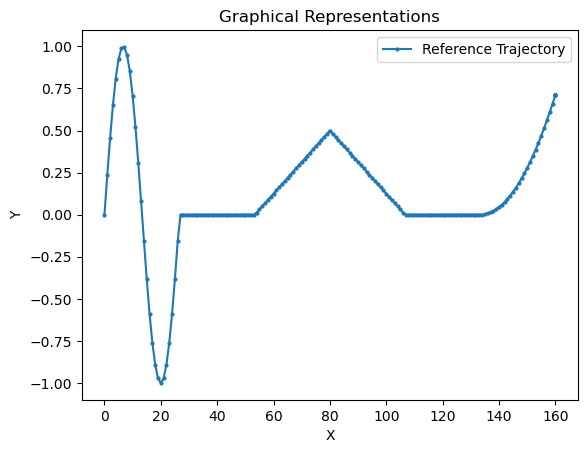

In [39]:
ref, velocity = assign_trajectory("random")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [40]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

### Plot Results

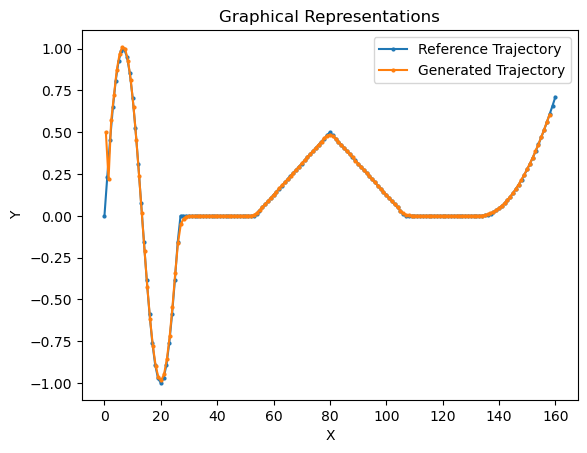

In [41]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(x_env[0:num_points - 1], y_env[0:num_points- 1], label="Generated Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Complex Trajectory.png")
plt.show()

### Save Files:

In [911]:
save_files(env, x_pred, y_pred, u_pred, ref)

## Increased Sampling Frequency: Square Trajectory

In [72]:
#global variables
angle = math.radians(45)
velocity = 1.2 #constant velocity
t = 0.5
distance = velocity * t
num_points = 320
steps = num_points

# Example parameters
w1 = 1.0  # Weight for the first term
w2 = 1.0  # Weight for the second term
p = 4     # Prediction Horizon = 5

bnds = ((-12.56, 12.56),(-12.56, 12.56),(-12.56, 12.56),(-12.56, 12.56))

#results:
u = np.zeros(steps + 1)
x_env = np.zeros(steps + 1)
y_env = np.zeros(steps + 1)

#initial points
x_env[0] = 0.5 
y_env[0] = 0.5
u[steps] = 0

u_pred = np.zeros((steps, p))
x_pred = np.zeros((steps, p + 1))
y_pred = np.zeros((steps, p + 1))

print(u_pred.shape)

(320, 4)


In [73]:
def gen_waypoints():
    ang = 0  # Start direction (0: right, 1: up, 2: left, 3: down)
    x_points = np.zeros(num_points + 1)
    y_points = np.zeros(num_points + 1)
    x_points[0] = 1
    y_points[0] = 2
    dx = 0.5  # Initially move right
    dy = 0
    
    for i in range(1, num_points + 1):
        x_points[i] = x_points[i - 1] + dx
        y_points[i] = y_points[i - 1] + dy
        
        # Change direction after every num_points/4 iterations, assuming a perfect square
        if i % (num_points // 4) == 0:
            ang += 1
            if ang == 1:  # Up
                dx, dy = 0, 0.5
            elif ang == 2:  # Left
                dx, dy = -0.5, 0
            elif ang == 3:  # Down
                dx, dy = 0, -0.5
            elif ang == 4:  # Right again
                dx, dy = 0.5, 0
                ang = 0  # Reset angle to start a new cycle if needed
        
    ref = np.vstack((x_points, y_points))
    return ref

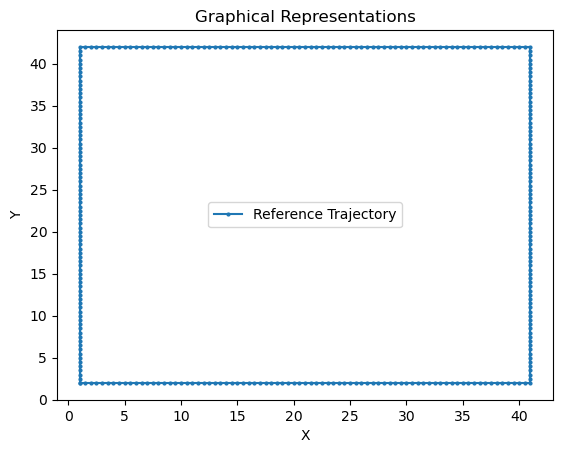

In [74]:
ref = gen_waypoints()

rx = ref[:-1,:][0]
ry = ref[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [75]:
# Extend rx by repeating the last element p times and appending
last_element_rx = rx[-1]
extension_rx = np.full(p, last_element_rx)
rx = np.concatenate((rx, extension_rx))

# Extend ry by repeating the last element p times and appending
last_element_ry = ry[-1]
extension_ry = np.full(p, last_element_ry)
ry = np.concatenate((ry, extension_ry))

# rx_extended and ry_extended are now the extended arrays
    
print(rx.shape)

(325,)


In [76]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

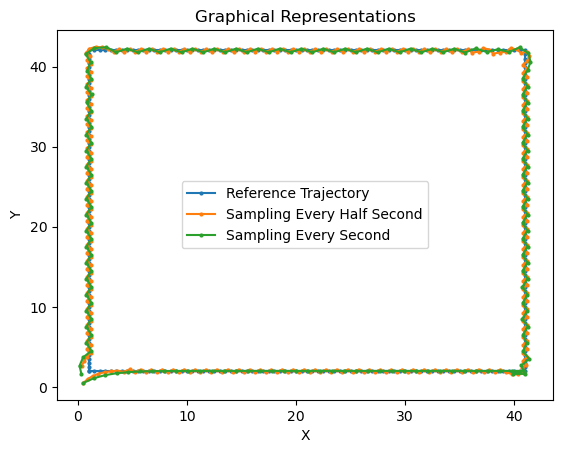

In [77]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]
sx = square_env[1,:]
sy = square_env[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(x_env[0:num_points], y_env[0:num_points], label="Sampling Every Half Second", marker='o', markersize=2)
plt.plot(sx[0:num_points], sy[0:num_points], label="Sampling Every Second", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Increased Sampling.png")
plt.show()

### Error

In [78]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 105.5167165493852


In [79]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 14.444644330489487


### Save Files

In [628]:
print(env.shape)

(3, 321)


In [629]:
save_files(env, x_pred, y_pred, u_pred, ref)

## Increased Prediction Horizon

In [99]:
#global variables
angle = math.radians(45)
velocity = 1 #velocity initialization
t = 1
num_points = 160
steps = num_points

# Example parameters
w1 = 1.0  # Weight for the first term
w2 = 1.0  # Weight for the second term
p = 15     # Prediction Horizon = 5

bnds = ((-12.56, 12.56),(-12.56, 12.56),(-12.56, 12.56),(-12.56, 12.56))

#results:
u = np.zeros(steps + 1)
x_env = np.zeros(steps + 1)
y_env = np.zeros(steps + 1)

#initial points
x_env[0] = 0.5 
y_env[0] = 0.5
u[steps] = 0

u_pred = np.zeros((steps, p))
x_pred = np.zeros((steps, p + 1))
y_pred = np.zeros((steps, p + 1))

ref = np.zeros((2, steps + 1))

print(ref.shape)

(2, 161)


### On Square Trajectory:

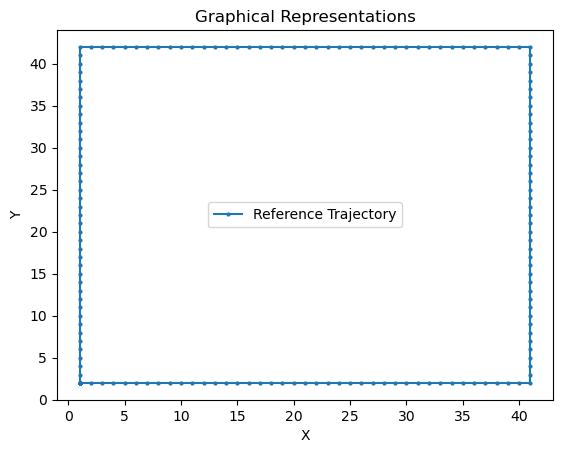

In [100]:
ref, velocity = assign_trajectory("square")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [101]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

In [102]:
sx = square_env[1,:][0]
sy = square_env[-1:,:][0]

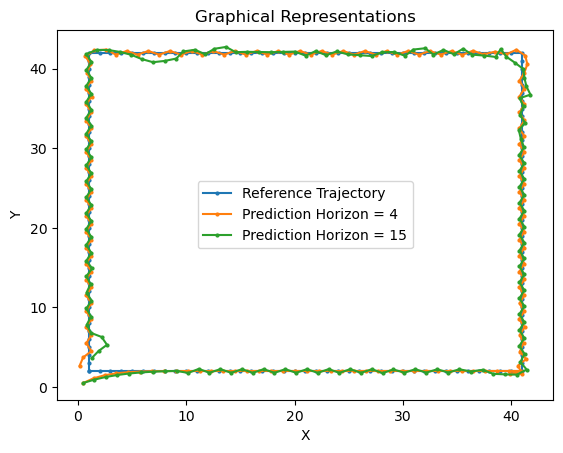

In [103]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]
sx = square_env[1,:]
sy = square_env[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(sx[0:num_points], sy[0:num_points], label="Prediction Horizon = 4", marker='o', markersize=2)
plt.plot(x_env[0:num_points], y_env[0:num_points], label="Prediction Horizon = 15", marker='o', markersize=2)

#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Pred_Square.png")
plt.show()

### Error

In [104]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 61.49380869140745


In [105]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 19.032502848599268


### Save Files

In [106]:
save_files(env, x_pred, y_pred, u_pred, ref)

### On Step Trajectory

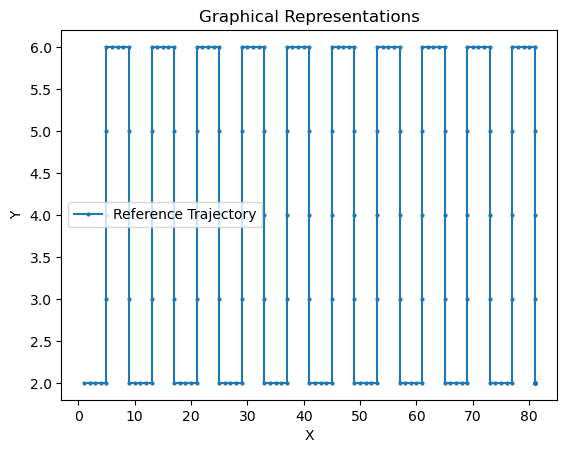

In [107]:
ref, velocity = assign_trajectory("step")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [108]:
MPC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

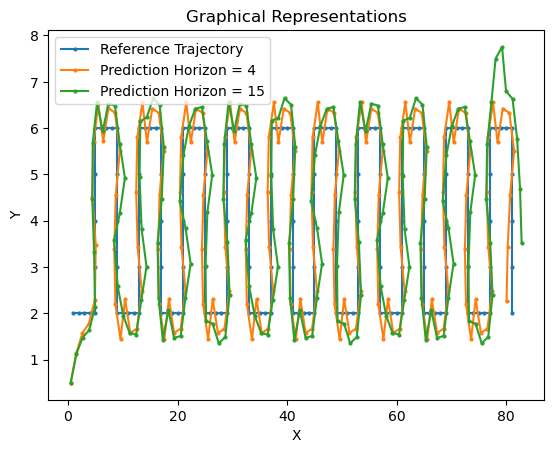

In [109]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]
sx = step_env[1,:]
sy = step_env[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(sx[0:num_points], sy[0:num_points], label="Prediction Horizon = 4", marker='o', markersize=2)
plt.plot(x_env[0:num_points], y_env[0:num_points], label="Prediction Horizon = 15", marker='o', markersize=2)

#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("Pred_Step.png")
plt.show()

### Error

In [110]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 108.17137622246491


In [111]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 22.17491814774562


### Save Files

In [649]:
save_files(env, x_pred, y_pred, u_pred, ref)

## SLSQP Optimisation: Square Trajectory

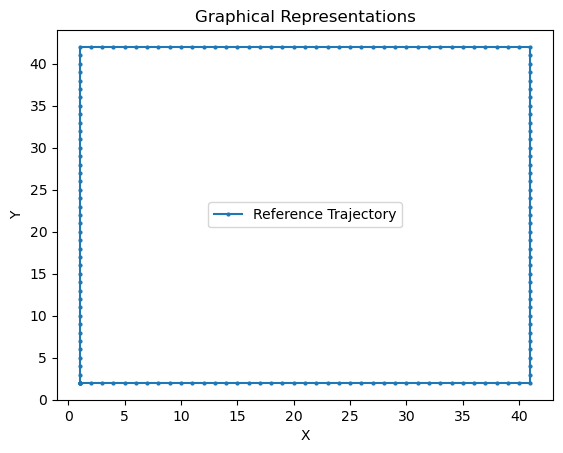

In [119]:
ref, velocity = assign_trajectory("square")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [122]:
def MPC_SLSQP(steps, x_env, y_env):
    k = 0
    for j in range(1, steps + 1):
        k += 1
        x_old = x_env[k - 1] # Initial value of x
        y_old = y_env[k - 1]  # Initial value of y
        
        r_x = rx[k : k+p] # Actual values for x (example)
        r_y = ry[k : k+p]  # Actual values for y (example)
        initial_u = np.zeros(p)  # Initial guess for control inputs

        # Perform optimization
        result = minimize(cost_function, np.zeros(p), args=(r_x, r_y, x_old, y_old, j), bounds = bnds, method = "SLSQP")

        # Optimized control inputs
        optimized_u = result.x
        #print(f"Optimized control inputs on run {j}: {optimized_u}")
        
        x_values = np.zeros(p + 1)  # Include initial x in the array
        y_values = np.zeros(p + 1)  # Include initial y in the array

        x_values[0] = x_old
        y_values[0] = y_old

        for i in range(1, p + 1):
            x_values[i] = x_values[i - 1] + distance * np.cos(optimized_u[i - 1])
            y_values[i] = y_values[i - 1] + distance * np.sin(optimized_u[i - 1])
            
        u[k - 1] = optimized_u[0]
        x_env[k] = x_values[1]
        y_env[k] = y_values[1]

        u_pred[k - 1, :] = optimized_u
        x_pred[k - 1, :] = x_values
        y_pred[k - 1, :] = y_values
    

In [123]:
MPC_SLSQP(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

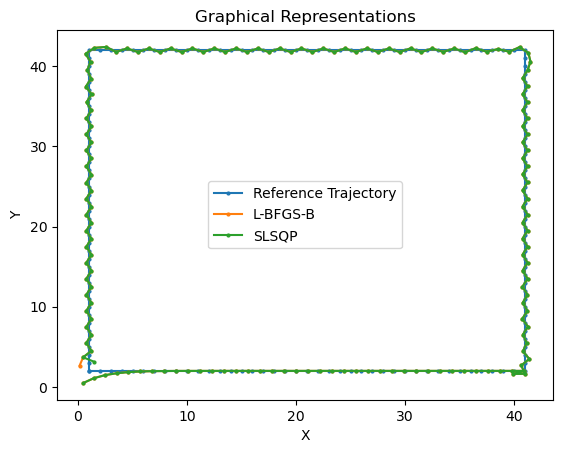

In [124]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]
sx = square_env[1,:]
sy = square_env[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(sx[0:num_points], sy[0:num_points], label="L-BFGS-B", marker='o', markersize=2)
plt.plot(x_env[0:num_points], y_env[0:num_points], label="SLSQP", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("SLSQP.png")
plt.show()

### Error

In [125]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 118.8653708105374


In [126]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 14.305893416649221


### Save Files

In [127]:
save_files(env, x_pred, y_pred, u_pred, ref)

## TNC Optimisation: Square Trajectory

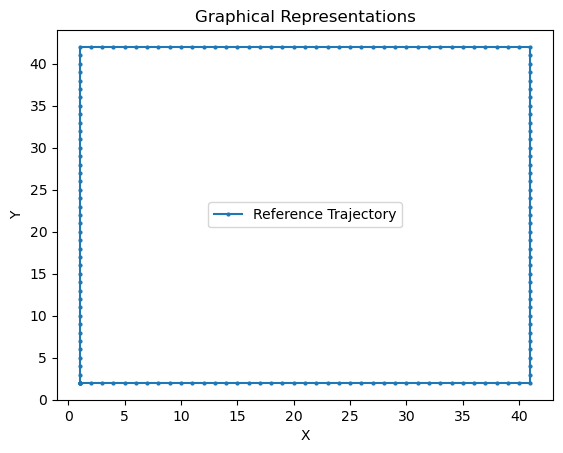

In [128]:
ref, velocity = assign_trajectory("square")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [129]:
def MPC_TNC(steps, x_env, y_env):
    k = 0
    for j in range(1, steps + 1):
        k += 1
        x_old = x_env[k - 1] # Initial value of x
        y_old = y_env[k - 1]  # Initial value of y
        
        r_x = rx[k : k+p] # Actual values for x (example)
        r_y = ry[k : k+p]  # Actual values for y (example)
        initial_u = np.zeros(p)  # Initial guess for control inputs

        # Perform optimization
        result = minimize(cost_function, np.zeros(p), args=(r_x, r_y, x_old, y_old, j), bounds = bnds, method = "TNC")

        # Optimized control inputs
        optimized_u = result.x
        #print(f"Optimized control inputs on run {j}: {optimized_u}")
        
        x_values = np.zeros(p + 1)  # Include initial x in the array
        y_values = np.zeros(p + 1)  # Include initial y in the array

        x_values[0] = x_old
        y_values[0] = y_old

        for i in range(1, p + 1):
            x_values[i] = x_values[i - 1] + distance * np.cos(optimized_u[i - 1])
            y_values[i] = y_values[i - 1] + distance * np.sin(optimized_u[i - 1])
            
        u[k - 1] = optimized_u[0]
        x_env[k] = x_values[1]
        y_env[k] = y_values[1]

        u_pred[k - 1, :] = optimized_u
        x_pred[k - 1, :] = x_values
        y_pred[k - 1, :] = y_values
    

In [130]:
MPC_TNC(steps, x_env, y_env)
env= np.vstack((u, x_env, y_env))

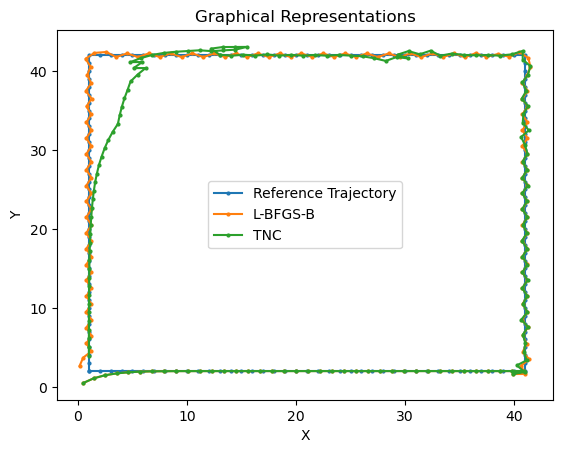

In [131]:
rx = ref[:-1,:][0]
ry = ref[-1:,:][0]
sx = square_env[1,:]
sy = square_env[-1:,:][0]

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
plt.plot(sx[0:num_points], sy[0:num_points], label="L-BFGS-B", marker='o', markersize=2)
plt.plot(x_env[0:num_points], y_env[0:num_points], label="TNC", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.savefig("TNC.png")
plt.show()

### Error

In [132]:
error = calculate_trajectory_error(env, ref)

# Print or use the error as needed
print(f"Total Trajectory Error: {error}")

Total Trajectory Error: 279.7783924297219


In [133]:
error = calculate_position_error(env, ref)

# Print or use the error as needed
print(f"Total Position Error: {error}")

Total Position Error: 15.318213827360621


### Save Files

In [134]:
save_files(env, x_pred, y_pred, u_pred, ref)

## Impact of Weights

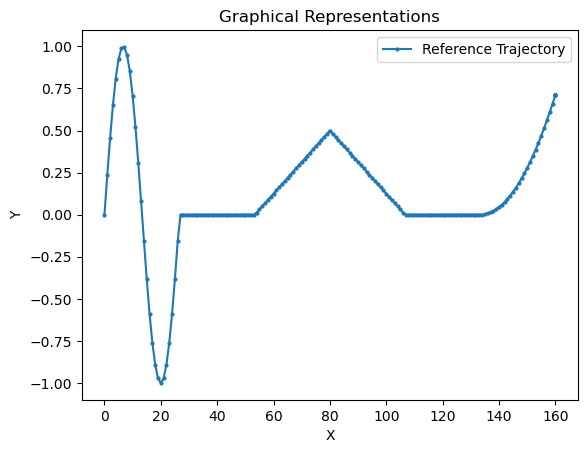

In [135]:
ref, velocity = assign_trajectory("random")
distance = velocity * t

rx, ry = extend_trajectory(ref)

plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
#plt.plot(iterations_history_3, objective_history_3, label="x_init = [3 1 4 3]", marker='o', markersize=2)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Graphical Representations')

plt.legend()
plt.show()

In [136]:
def weight_values(case):
    if case == 0:
    #Base Case 0: W1 = W2
        w1 = 0.1 # Weight for the first term
        w2 = 0.1  # Weight for the second term
    elif case == 1:
    #Case 1: W1 > W2
        w1 = 0.2
        w2 = 0.1
    elif case == 2:
    #Case 2: W1 > W2 bigger ratio
        w1 = 1
        w2 = 0.1
    elif case == 3:
    #Case 3: W1 < W2
        w1 = 0.1
        w2 = 0.2
    elif case == 4:
    #Case 4: W1 < W2 bigger ratio
        w1 = 0.1
        w2 = 1
    else:
        raise ValueError("Invalid case number")
    return w1, w2

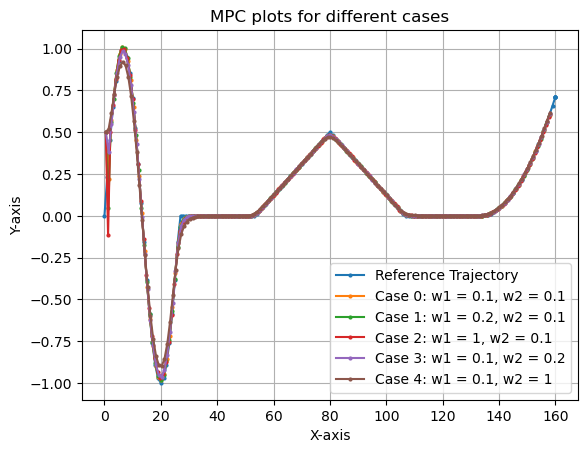

In [137]:
def plot_weights():
    plt.figure(figsize=(10, 6))
plt.plot(rx, ry, label="Reference Trajectory", marker='o', markersize=2)
for i in range(0,5):
    w1,w2 = weight_values(i)
    MPC(num_points, x_env, y_env)
    plt.plot(x_env[0:num_points - 1], y_env[0:num_points - 1], label=f"Case {i}: w1 = {w1}, w2 = {w2}", marker='o', markersize=2)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('MPC plots for different cases')
plt.legend()
plt.grid(True)
plt.savefig("Different Weights.png")
plt.show()